In [0]:
import os
import shutil
import torch
import collections
from torchvision import transforms,datasets
from __future__ import print_function, division
import os
import torch
import pylab
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import zipfile as zf
from fastai.vision import *
from fastai.metrics import error_rate
from pathlib import Path
from glob2 import glob
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import os
import zipfile as zf
import shutil
import re
import seaborn as sns
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
 
plt.ion()   # interactive mode


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import math
from PIL import Image
 
class Resize(object):
    """Resize the input PIL Image to the given size.
    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """
 
    def __init__(self, size, interpolation=Image.BILINEAR):
        # assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation
 
    def __call__(self, img):
        w,h = img.size
        
        min_edge = min(img.size)
        rate = min_edge / self.size
        
        new_w = math.ceil(w / rate)
        new_h = math.ceil(h / rate)
        
        return img.resize((new_w,new_h))


In [0]:
from google.colab import drive
drive.mount("/content/drive")
files = zf.ZipFile("/content/drive/My Drive/python/dataset-resized.zip","r")
files.extractall()
files.close()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.listdir(os.path.join(os.getcwd(),"dataset-resized"))

['plastic', 'paper', 'glass', 'trash', 'cardboard', '.DS_Store', 'metal']

In [0]:
def split_indices(folder,seed1):    
    n = len(os.listdir(folder))
    full_set = list(range(1,n+1))

    ## train indices
    random.seed(seed1)
    train = random.sample(list(range(1,n+1)),int(.8*n))

    ##  test
    test = list(set(full_set)-set(train))
    
    return(train,test)

## gets file names for a particular type of trash, given indices
    ## input: waste category and indices
    ## output: file names 
def get_names(waste_type,indices):
    file_names = [waste_type+str(i)+".jpg" for i in indices]
    return(file_names)    

## moves group of source files to another folder
    ## input: list of source files and destination folder
    ## no output
def move_files(source_files,destination_folder):
    for file in source_files:
        shutil.move(file,destination_folder)

In [0]:
## paths will be train/cardboard, train/glass, etc...
waste_types = ['cardboard','glass','metal','paper','plastic','trash']

## create destination folders for data subset and waste type
for waste_type in waste_types:
      folder = os.path.join('data','train',waste_type)
      if not os.path.exists(folder):
          os.makedirs(folder)
            
# if not os.path.exists(os.path.join('data','test')):
#     os.makedirs(os.path.join('data','test'))
for waste_type in waste_types:
      folder = os.path.join('data','test',waste_type)
      if not os.path.exists(folder):
          os.makedirs(folder)

In [0]:
## move files to destination folders for each waste type
for waste_type in waste_types:
    source_folder = os.path.join('dataset-resized',waste_type)
    train_ind,test_ind = split_indices(source_folder,1)
    
    ## move source files to train
    train_names = get_names(waste_type,train_ind)
    train_source_files = [os.path.join(source_folder,name) for name in train_names]
    train_dest = "data/train/"+waste_type
    move_files(train_source_files,train_dest)
    
    ## move source files to test
    test_names = get_names(waste_type,test_ind)
    test_source_files = [os.path.join(source_folder,name) for name in test_names]
    ## I use data/test here because the images can be mixed up
    test_dest = "data/test/"+waste_type
    move_files(test_source_files,test_dest)

In [0]:
# path = Path(os.getcwd())/"data"
# path

In [0]:
data_transform = transforms.Compose([
    Resize(84),
    transforms.CenterCrop(84),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
    
])
 
train_dataset = datasets.ImageFolder(root = '/content/data/train/',transform = data_transform)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = 16,shuffle = True,num_workers = 4)
 
test_dataset = datasets.ImageFolder(root = '/content/data/test/',transform = data_transform)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 16,shuffle = True,num_workers = 4)


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16 * 18 * 18,800)
        self.fc2 = nn.Linear(800,120)
        self.fc3 = nn.Linear(120,6)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,16 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
 
net = Net()


In [0]:
import torch.optim as optim
 
cirterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.004,momentum = 0.9)
 
for epoch in range(40):
    running_loss = 0.0
    print("epoch"+str(epoch))
    for i,data in enumerate(train_loader,0):
        print(i)
        inputs,labels = data
        inputs,labels = Variable(inputs),Variable(labels)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = cirterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i % 126 == 0) and (i!=0):
            print('[%d %5d] loss: %.3f' % (epoch + 1,i + 1,running_loss / 126))
            running_loss = 0.0
 
print('finished training!')


流式输出内容被截断，只能显示最后 5000 行内容。
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
[2   127] loss: 1.566
epoch2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
[3   127] loss: 1.450
epoch3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71

In [0]:
correct = 0
total = 0
 
for data in test_loader:
    images,labels = data
    outputs = net(Variable(images))
    _,predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
 
print('Accuracy of the network on the 5000 test images: %d %%' % (100 * correct / total))


Accuracy of the network on the 5000 test images: 61 %


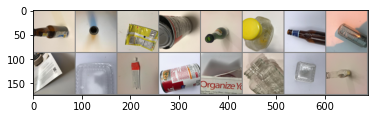

图像标签为：
GroundTruth:  glass glass trash metal glass plastic glass metal paper plastic trash metal paper glass plastic glass
预测结果为：
Predicted:  glass glass plastic plastic glass cardboard glass metal paper plastic trash paper paper glass plastic glass


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision


def imshow(img):
  img = img/2+0.5 
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()


dataiter=iter(test_loader)
images,labels=dataiter.next()


imshow(torchvision.utils.make_grid(images))
print("图像标签为：")
print('GroundTruth: ', ' '.join('%5s'% waste_types[labels[j]] for j in range(16)))
outputs = net(images)
predicted=torch.max(outputs,1)[1].numpy()
print("预测结果为：")
print('Predicted: ', ' '.join('%5s'% waste_types[predicted[j]] for j in range(16)))
